In [1]:
import pandas as pd
import numpy as np
import math
import keras
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('df5_2102.csv')

sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

In [47]:
import random
for col in ['operation_'+ str(_id) for _id in freezer_id]:
    df[col+'_random'] = [random.randint(0,1) for r in range(len(df))]

In [48]:
cols = ['gw_time'] + ['temperature_329'] + ['temperature_329_prime'] + ['dT_329'] + ['operation_'+str(_id) for _id in freezer_id]+['freez_run_'+str(_id) for _id in freezer_id] +['operation_'+str(_id)+'_random' for _id in freezer_id]
df = df[cols]

In [49]:
df = df.dropna()

In [53]:
import seaborn as sns

df['dT_329'].unique()

array([ 0.01, -0.01,  0.  , -0.01,  0.01,  0.02, -0.02, -0.03,  0.02,
        0.05, -0.03, -0.04, -0.02, -0.04,  0.03,  0.04,  0.04, -0.05,
        0.05,  0.03, -0.07, -0.06, -0.06, -0.08, -0.05, -0.09,  0.07,
        0.09,  0.11,  0.08,  0.08,  0.06, -0.08,  0.12,  0.06,  0.07])

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_15332\1895644849.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['dT_329'])


<AxesSubplot: xlabel='dT_329', ylabel='Density'>

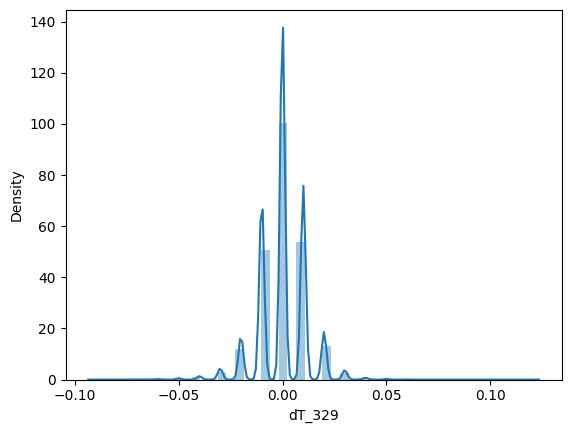

In [69]:
sns.distplot(df['dT_329'])

In [73]:
idx = df[df['dT_329'] >= 0.02].index

In [74]:
df_processed = df.drop(index= idx)

In [ ]:
df['dT_329'] = np.round(df['dT_329'], 2)

In [100]:
df['dT_329'].unique()

array([ 0.01, -0.01,  0.  ,  0.02, -0.02, -0.03,  0.05, -0.04,  0.03,
        0.04, -0.05, -0.07, -0.06, -0.08, -0.09,  0.07,  0.09,  0.11,
        0.08,  0.06,  0.12])

<AxesSubplot: >

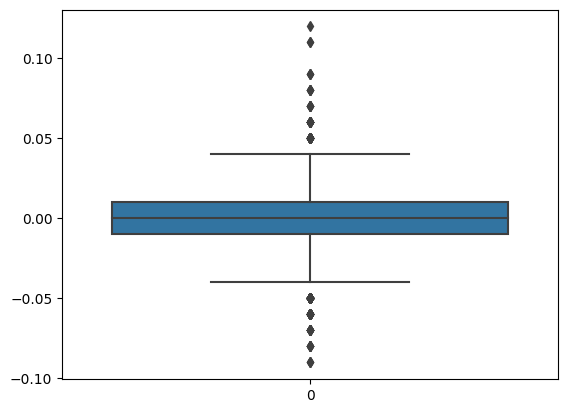

In [101]:
sns.boxplot(df['dT_329'].reset_index(drop = True))

In [102]:
df['dT_329'].quantile(0.75)

0.01

In [103]:
df['dT_329'].value_counts()/len(df)

 0.00    0.420769
 0.01    0.226435
-0.01    0.212993
 0.02    0.055492
-0.02    0.050986
-0.03    0.012893
 0.03    0.010959
-0.04    0.003932
 0.04    0.002059
-0.05    0.001560
 0.05    0.000612
-0.06    0.000587
 0.06    0.000212
-0.07    0.000175
-0.08    0.000087
 0.07    0.000075
 0.08    0.000062
-0.09    0.000037
 0.09    0.000037
 0.11    0.000025
 0.12    0.000012
Name: dT_329, dtype: float64

<AxesSubplot: >

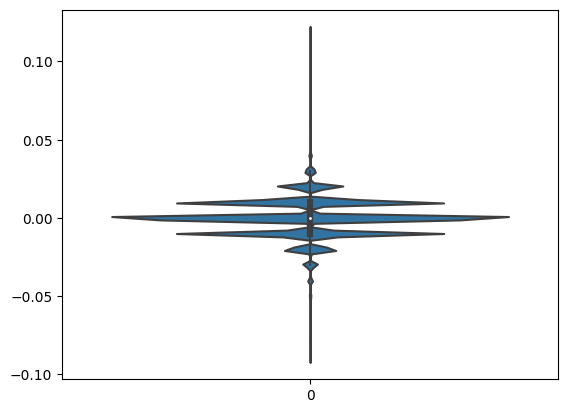

In [60]:
sns.violinplot(df['dT_329'].reset_index(drop = True))

In [77]:
df_processed = df_processed.reset_index(drop = True)

In [78]:
# TEST_SIZE = 8000
# train = df[:-TEST_SIZE]
# test = df[-TEST_SIZE:]
# train.shape, test.shape

TEST_SIZE = 8000
train = df_processed[:-TEST_SIZE]
test = df_processed[-TEST_SIZE:]
train.shape, test.shape

((70512, 13), (8000, 13))

In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
for col in cols[1:-3]:
    train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
    test[col] = scaler_train.transform(test[col].values.reshape(-1,1))

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_15332\2236184520.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_15332\2236184520.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler_train.transform(test[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_15332\2236184520.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [80]:
feature_cols1 = ['freez_run_'+str(_id) for _id in freezer_id] #+ ['temperature_329_prime']
feature_cols2 = ['operation_'+str(_id)+'_random' for _id in freezer_id] #+ ['temperature_329_prime']
label_cols =  ['dT_329']

In [81]:
train_feature = train[feature_cols1]
train_feature2 = train[feature_cols2]
train_label = train[label_cols]

# train, validation set 생성
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_feature,train_label,test_size=0.1, shuffle= False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_feature2,train_label,test_size=0.1, shuffle= False)
X_test2.columns = X_test.columns
X_train.shape, X_test.shape
# ((57676, 20, 21), (14419, 20, 21))

((63460, 3), (7052, 3))

In [82]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [83]:
print(len(X_train), len(X_test))
xgb_model.fit(X_train,y_train)

63460 7052


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [84]:
predictions = xgb_model.predict(X_test)
predictions2 = xgb_model.predict(X_test2)
predictions

array([0.7970971, 0.7970971, 0.7970971, ..., 0.8104451, 0.8104451,
       0.8104451], dtype=float32)

In [85]:
r_sq = xgb_model.score(X_train, y_train)
print(r_sq)
print(explained_variance_score(predictions,y_test))

0.06846950944350261
-28.449591850573306


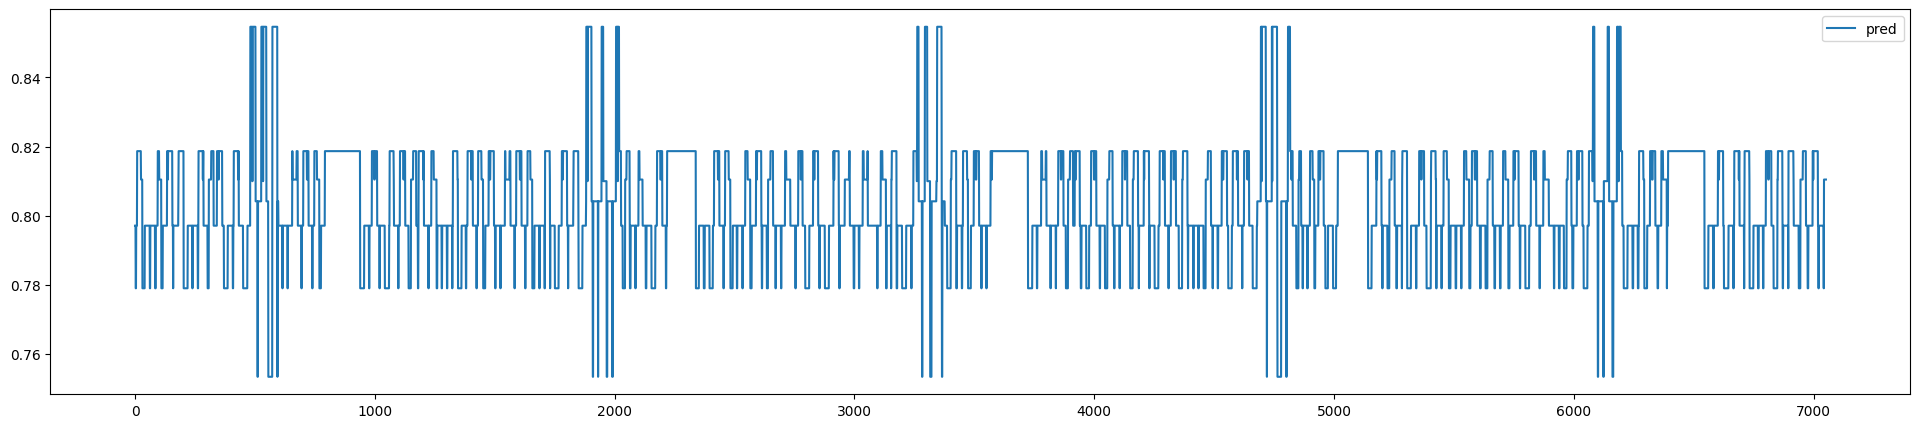

In [86]:
plt.figure(figsize=(24,5))
# plt.plot(y_test.reset_index(drop = True), label = 'actual')
plt.plot(predictions, label = 'pred')
plt.legend()
plt.show()

In [87]:
np.unique(predictions)

array([0.75337756, 0.77898586, 0.7970971 , 0.8041465 , 0.8099789 ,
       0.8104451 , 0.8186651 , 0.8546488 ], dtype=float32)

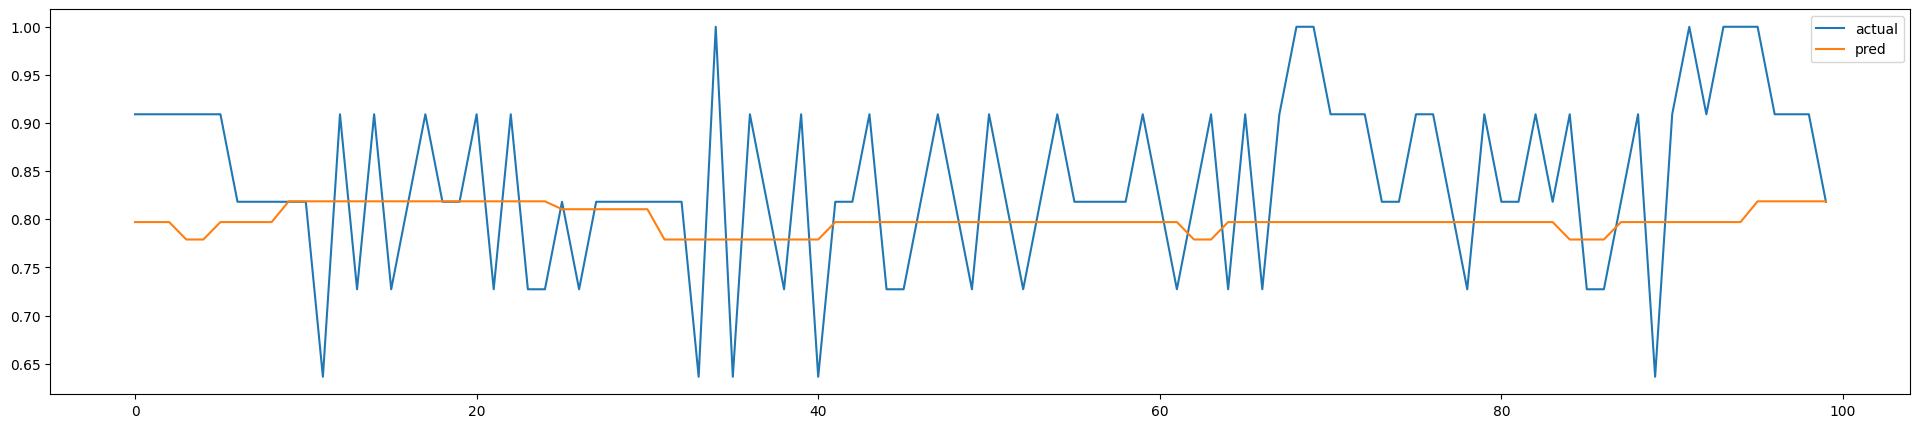

In [88]:
plt.figure(figsize=(24,5))
plt.plot(y_test.reset_index(drop = True)[:100], label = 'actual')
plt.plot(predictions[:100], label = 'pred')
plt.legend()
plt.show()

In [45]:
df

,gw_time,temperature_329,temperature_329_prime,dT_329,operation_344,operation_362,operation_368,freez_run_344,freez_run_362,freez_run_368,operation_344_random,operation_362_random,operation_368_random
9,2021-02-01 00:04:36,-20.28,-20.29,0.01,0.0,1.0,1.0,0.0,0.0,1.0,0,0,1
10,2021-02-01 00:05:06,-20.29,-20.28,-0.01,0.0,1.0,1.0,0.0,0.0,1.0,0,1,1
11,2021-02-01 00:05:36,-20.29,-20.29,0.00,0.0,1.0,1.0,0.0,0.0,1.0,0,1,0
12,2021-02-01 00:06:06,-20.29,-20.29,0.00,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0
13,2021-02-01 00:06:36,-20.30,-20.29,-0.01,0.0,1.0,1.0,0.0,0.0,1.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80124,2021-02-28 23:57:33,-18.94,-18.94,0.00,1.0,1.0,1.0,1.0,0.0,1.0,0,1,0
80125,2021-02-28 23:58:03,-18.95,-18.94,-0.01,1.0,1.0,1.0,1.0,0.0,1.0,1,0,0
80126,2021-02-28 23:58:33,-18.93,-18.95,0.02,1.0,1.0,1.0,1.0,0.0,1.0,0,0,0
80127,2021-02-28 23:59:03,-18.95,-18.93,-0.02,1.0,1.0,1.0,1.0,0.0,1.0,0,0,1
